## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for image in images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    corners_found, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if corners_found:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, corners_found)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### Now I have `objpoints` and `imgpoints` needed for camera calibration. The next step is to calibrate the camera, and calculate distortion coefficients using a distorted image:

Text(0.5,1,'Undistorted Image')

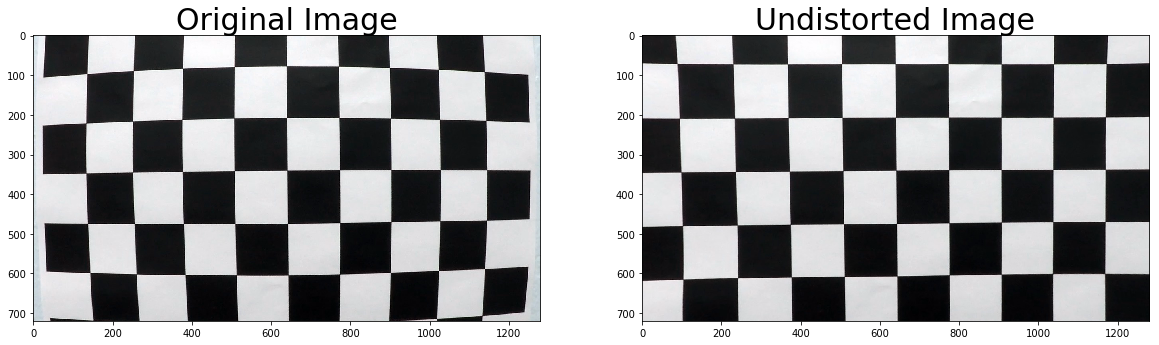

In [3]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('images/undist_cb_output.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
import pickle

# Save the calculated matrix & distortion coefficients for later use
dist_coeff_pickle = {}
dist_coeff_pickle["mtx"] = mtx
dist_coeff_pickle["dist"] = dist
pickle.dump(dist_coeff_pickle, open( "./dist_coeff.p", "wb" ))

### With the calibrated camera (using the calculated matrix & distortion coefficients), now I can undistort any image as follows:

Text(0.5,1,'Undistorted Image')

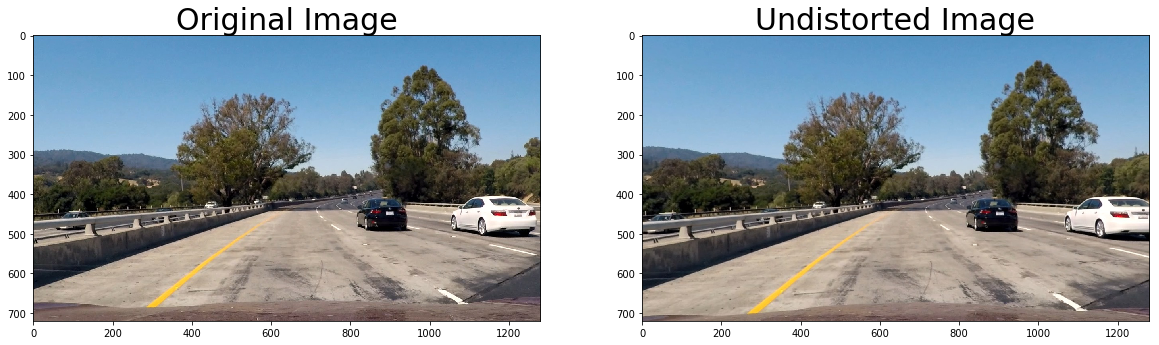

In [5]:
img = cv2.imread('./test_images/test1.jpg')

undst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./images/undist_test1.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(undst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

In [6]:
# This is optional. Useful when suspending & resuming work 
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open("dist_coeff.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

### These helper functions, to transform the image using Sobel X/Y, magnitude, HLS/HSV/RGB channel thresholds, facilitate reuse of code and allow easy experimentation of various combinations. 

In [7]:
def transform_binary(raw, thresh):
    # 2) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    thresh_min, thresh_max = thresh
    binary_output = np.zeros_like(raw)
    binary_output[(raw >= thresh_min) & (raw <= thresh_max)] = 1
    return binary_output
    
def sobel_binary(abs_sobel, thresh):
    # 1) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    sobel_thresh = transform_binary(scaled_sobel, thresh)
    return sobel_thresh
    
def sobel_transform(gray, thresh, orient='x', kernel_size=5):
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F,
        int(orient == 'x'), int(orient == 'y'), ksize=kernel_size)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Generate output binary
    sobel_transformed = sobel_binary(abs_sobel, thresh)
    return sobel_transformed

def mag_transform(gray, thresh, kernel_size=5):
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    # 2) Calculate the magnitude
    abs_sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # 3) Generate output binary
    mag_transformed = sobel_binary(abs_sobel, thresh)
    return mag_transformed

def hls_transform(hls, thresh, space='S'):
    # Separate the H/L/S channel
    spaces = ['H', 'L', 'S']
    hls_channel = hls[:,:,spaces.index(space)]
    # Threshold S channel
    hls_transformed = transform_binary(hls_channel, thresh)
    return hls_transformed

def hsv_transform(hsv, thresh, space='H'):
    # Separate the H/L/S channel
    spaces = ['H', 'S', 'V']
    hsv_channel = hsv[:,:,spaces.index(space)]
    # Threshold S channel
    hsv_transformed = transform_binary(hsv_channel, thresh)
    return hsv_transformed

def color_transform(rgb, thresh, color='R'):
    # Separate the R/G/B channel
    colors = ['R', 'G', 'B']
    c_channel = rgb[:,:,colors.index(color)]
    single_transformed = transform_binary(c_channel, thresh)
    return single_transformed

### The function below will unwarp an area given its coordinates. I experimented with various values for the source and destination vertices until I found a good combination that unwarps a trapezoidal area in an image containing straight lines into a rectangular area enclosed within 2 parallel lane lines.

In [24]:
def unwarp(img):
    img_shape = img.shape
    src = np.array([[ 
        (0.47 * img_shape[1], 0.62 * img_shape[0]),
        (0.54 * img_shape[1], 0.62 * img_shape[0]), 
        (0.86 * img_shape[1], img_shape[0]),
        (0.16 * img_shape[1], img_shape[0])
        ]], dtype=np.float32)
    dst = np.array([[ 
        (0.25 * img_shape[1], 0),
        (0.81 * img_shape[1], 0), 
        (0.75 * img_shape[1], img_shape[0]),
        (0.25 * img_shape[1], img_shape[0])
        ]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped, M, Minv

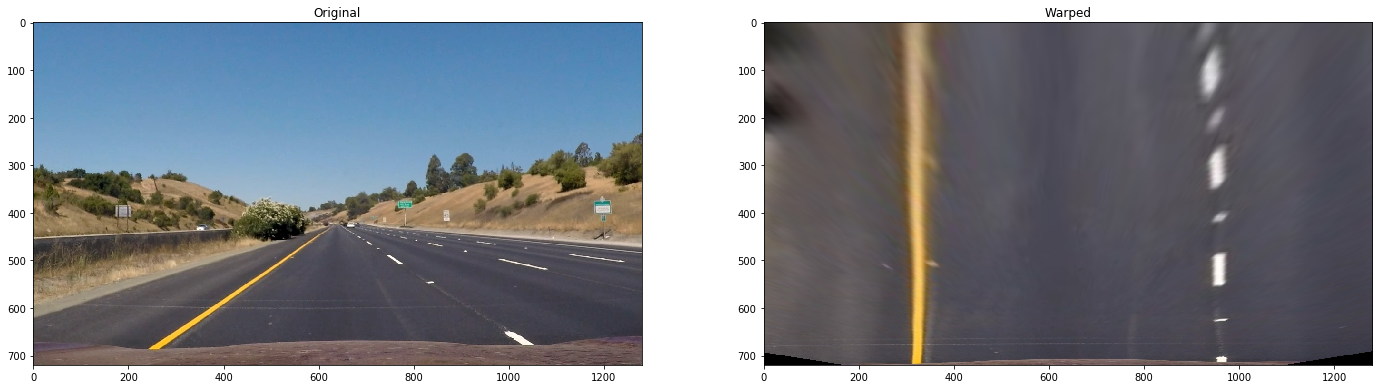

In [25]:
img = cv2.imread('./test_images/straight_lines1.jpg')
undst = cv2.undistort(img, mtx, dist, None, mtx)
warped, M, Minv = unwarp(undst)
cv2.imwrite('./output_images/warped_straight_lines1.jpg', warped)
fig = plt.figure(figsize=(24, 9))
canvas = fig.add_subplot(1, 2, 1)
canvas.set_title('Original')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
canvas = fig.add_subplot(1, 2, 2)
canvas.set_title('Warped')
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

### The function below undistorts and transforms the input image into a grayscale image with the left and right boundaries of the vehicle's lane prominently identified. I experimented with various combinations of transforms defined in the functions above, and with various threshold values until I found a good combination that works for all 6 test images.   

In [26]:
### Try various combinations of transforms to find a working combo that identifies lanes
def undistort_transform(img, mtx, dist, sobel_thresh=(30, 120), s_thresh=(180, 255), c_thresh=(202, 255)):
    # img is an original, possibly distorted image
    undst = cv2.undistort(img, mtx, dist, None, mtx)

    # Convert to HLS color space
    hls = cv2.cvtColor(undst, cv2.COLOR_BGR2HLS)
    # Threshold S channel
    s_binary = hls_transform(hls, s_thresh)
    
    # Grayscale image
    gray = cv2.cvtColor(undst, cv2.COLOR_BGR2GRAY)
    # Sobel x
    sxbinary = sobel_transform(gray, sobel_thresh)
    mag_binary = mag_transform(gray, sobel_thresh)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    # Threshold R, G channels
    r_binary = color_transform(undst, c_thresh)
    g_binary = color_transform(undst, c_thresh, color='G')
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (r_binary == 1) | (g_binary == 1)] = 1
    
    return combined_binary

### The first function below is used to find a 2nd degree polynomial to fit each of the lane line boundaries. It will blindly search for a fitting polynomial using the sliding windows code provided in Lesson 15, or use previously found polynomial to search for lines in a region around the previously found lines. The second function will perform a sanity check - whether the lines found are parallel within a given error margin or not (which is especially useful when not performing blind search).

In [35]:
def fit_lines_sliding_window(binary_warped, margin=120, blind_search=True, left_fit=[], right_fit=[]):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create an output image to draw on and  visualize the result
    # Remove left & right edges to avoid finding lines outside the lane boundaries
    hist_img = np.zeros_like(binary_warped)
    margin = 100
    hist_img[margin:,:-margin] = binary_warped[margin:,:-margin]
    out_img = np.dstack((hist_img, hist_img, hist_img))*255
    
    # Search for lines using sliding windows only if blind_search flag is set
    if blind_search:
        # Take a histogram of the bottom half of the image
        histogram = np.sum(hist_img[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set minimum number of pixels found to recenter window
        minpix = 50
    
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        # Assume left_fit and right_fit were provided (searched earlier)
        # Search in a margin around the previous line position
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return out_img, left_fit, right_fit

def check_sanity(num_pts, left_fit, right_fit, error_margin=80):
    # Generate x and y values for plotting
    ploty = np.linspace(0, num_pts - 1, num_pts)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    sane = True
    #indices = np.random.random_integers(ploty.shape[0], size=3)
    error = np.absolute((right_fitx[-1] - left_fitx[-1]) - (right_fitx[0] - left_fitx[0]))
    sane = sane and error <= error_margin
    return sane

### Now I define a function that will generate the desired output image using the previously defined functions that perform undistortion, transformation, polynomial fitting followed by the code from Lesson 15 and the FAQ video to mark the lane boundaries, lane area, position from center, and radius of curvature. This function also has code to visualize & save the results of intermediate steps and the final step (which will be useful for the writeup).

In [40]:
# Define a pipeline of image processing to get the desired end result
def find_lane_pipeline(img, left_fit=[], right_fit=[], image_path=None, plot=False, save=False):
    if image_path:
        img = cv2.imread(image_path)
    
    # combined_binary1 = undistort_transform(image, mtx, dist, color_channel_thresh=False)
    combined_binary = undistort_transform(img, mtx, dist)
    
    # Warp the image to straighten the lanes
    warped = cv2.warpPerspective(combined_binary, M, (img.shape[1], img.shape[0]))
    
    # Set the width of the windows +/- margin
    margin = 130
    
    # Turn off blind search by default. Let the pipeline function decide whether to search using sliding windows.
    blind_search = False
    
    
    if len(left_fit) != 3:
        # Find the lane line polynomials using sliding windows
        img_w_lines, left_fit, right_fit = fit_lines_sliding_window(warped, margin=margin)
        # Blindly search with sliding windows for the first image
        blind_search = True

    else:
        # Use polynomials found earlier using sliding windows
        img_w_lines, left_fit, right_fit = fit_lines_sliding_window(
            warped, margin=margin, blind_search=False, left_fit=left_fit, right_fit=right_fit)
        num_pts = img.shape[0]
        sane = check_sanity(num_pts, left_fit, right_fit)
        # If sanity check fails, find polynomial fit again using sliding windows
        if not sane:
            img_w_lines, left_fit, right_fit = fit_lines_sliding_window(warped, margin=margin)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    window_width = 50
    # Generate another image with lane lines and the area between those 2 lines
    left_lane = np.array(list(zip(
        np.concatenate((left_fitx - window_width/2, left_fitx[::-1] + window_width/2), axis=0),
        np.concatenate((ploty, ploty[::-1]), axis=0)
        )), np.int32)
    right_lane = np.array(list(zip(
        np.concatenate((right_fitx - window_width/2, right_fitx[::-1] + window_width/2), axis=0),
        np.concatenate((ploty, ploty[::-1]), axis=0)
        )), np.int32)
    lane_area = np.array(list(zip(
        np.concatenate((left_fitx + window_width/2, right_fitx[::-1] - window_width/2), axis=0),
        np.concatenate((ploty, ploty[::-1]), axis=0)
        )), np.int32)
    lanes = np.zeros_like(img)
    cv2.fillPoly(lanes, [left_lane], color=[255,51,153])
    cv2.fillPoly(lanes, [right_lane], color=[255,153,51])
    cv2.fillPoly(lanes, [lane_area], (153,255,51))
    # Unwarp the image of colored lanes
    unwarped_lanes = cv2.warpPerspective(lanes, Minv, (img.shape[1], img.shape[0]))
    # Superimpose colored lanes on the original image
    output = cv2.addWeighted(img, 1, unwarped_lanes, 0.5, 0)
    
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Define conversions in x and y from pixels space to meters
    # Find lane width
    indices = [0, ploty.shape[0]//2, ploty.shape[0]-1]
    lane_width = 0
    for indx in indices:
        lane_width += right_fitx[indx] - left_fitx[indx]
    lane_width /= len(indices)
    #print(lane_width)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/lane_width # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    curverad = round((left_curverad + right_curverad)/2, 3)
    curverad_str = str(curverad) if curverad < 5000 else '5000'
    cr = 'Radius of Curvature: ' + curverad_str + ' m'
    #print(cr)
    
    # Calculate the position from center
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    position = xm_per_pix * (camera_center - warped.shape[1] / 2)
    side = 'Left' if position < 0 else 'Right'
    pos = 'Vehicle is ' + str(round(np.absolute(position), 3)) + ' m ' + side + ' of the Center'
    
    # Add position, curvature to the output image
    cv2.putText(output, cr, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(output, pos, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    image_name = None
    if image_path:
        image_name = image_path.split('/')[-1]
    
    if plot:
        plt_scale = 6
        num_images = len(images)
        pos = 1
        fig = plt.figure(figsize=(plt_scale * 3, plt_scale * num_images / 2))

        # Plot the original image
        canvas = fig.add_subplot(num_images, 4, pos)
        canvas.set_title('Original ' + image_name)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        pos +=1
    
        # Plot the transformed image
        canvas = fig.add_subplot(num_images, 4, pos)
        canvas.set_title('Transformed ' + image_name)
        plt.imshow(combined_binary, cmap='gray')
        #plt.imshow(corners_unwarp(combined_binary), cmap='gray')
        pos +=1
    
        # Plot the warped image
        canvas = fig.add_subplot(num_images, 4, pos)
        canvas.set_title('Warped ' + image_name)
        plt.imshow(warped, cmap='gray')
        pos +=1

        # Visualize the lane lines found by polynomial fitting
        if blind_search:
            vis_img = img_w_lines
            
        else:
            window_img = np.zeros_like(img_w_lines)

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                          ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                          ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0), 4)
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0), 4)
            vis_img = cv2.addWeighted(img_w_lines, 1, window_img, 0.3, 0)
           
        # Draw the lane onto the warped blank image
        # Plot the image with lines
        canvas = fig.add_subplot(num_images, 4, pos)
        canvas.set_title('Find Lines ' + image_name)

        plt.imshow(vis_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, warped.shape[1])
        plt.ylim(warped.shape[0], 0)
        pos +=1

    if save:
        # Save the transformation result
        cv2.imwrite('./output_images/combined_' + image_name, np.uint8(255 * combined_binary))
        # Save the warping result
        cv2.imwrite('./output_images/warped_' + image_name, np.uint8(255 * warped))
        # Save the identified lanes
        cv2.imwrite('./output_images/lanes_' + image_name, lanes)
        # Save the final output = lanes + original image
        cv2.imwrite('./output_images/output_' + image_name, output)

    return output, left_fit, right_fit

### Test the code using the available test images. This was useful to fix bugs, and iterate until the code generates desired output.

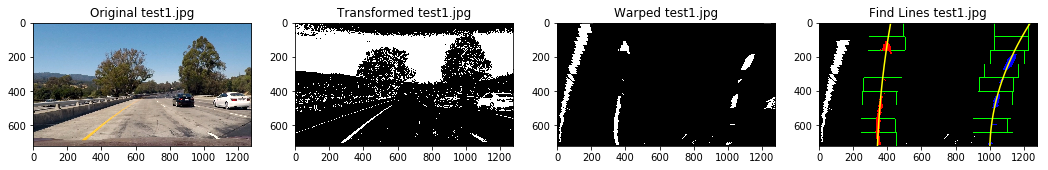

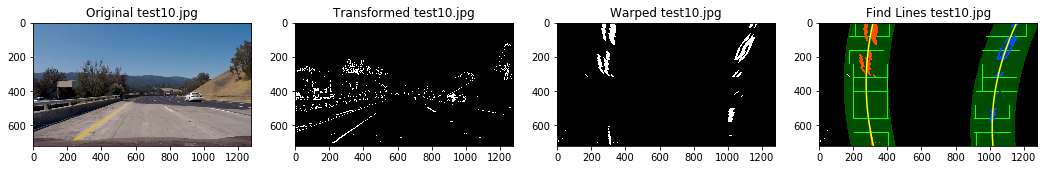

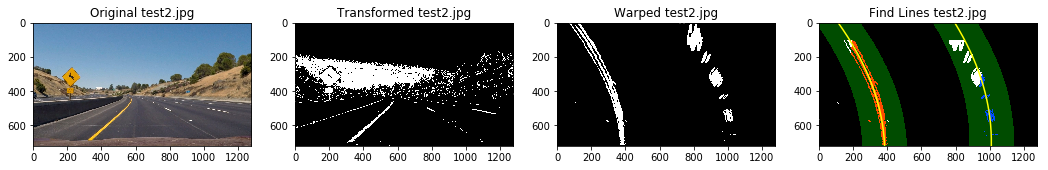

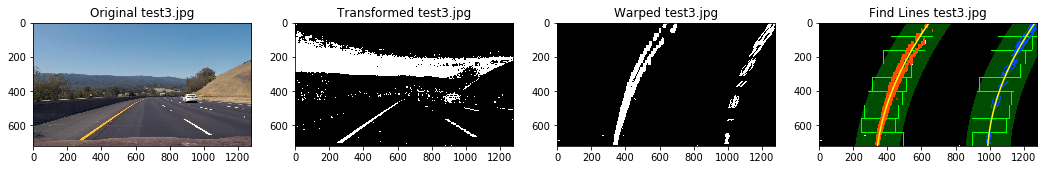

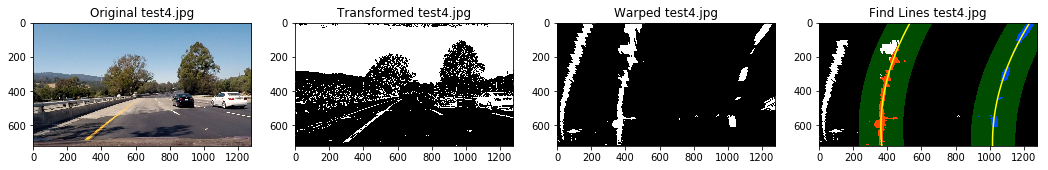

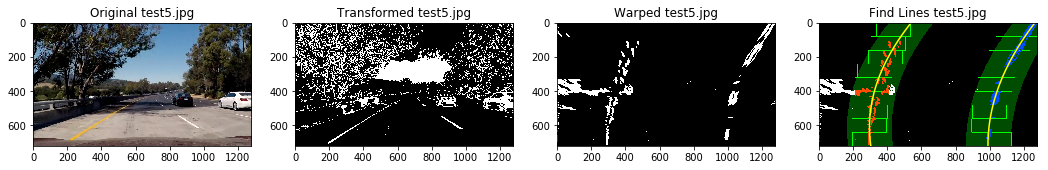

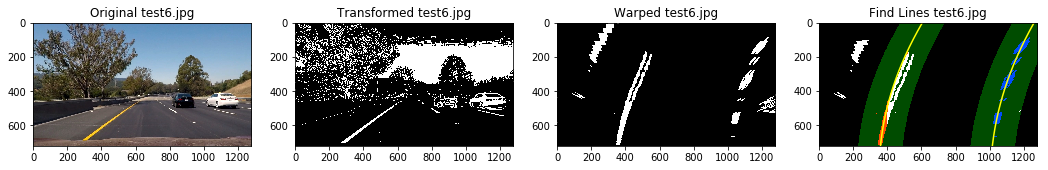

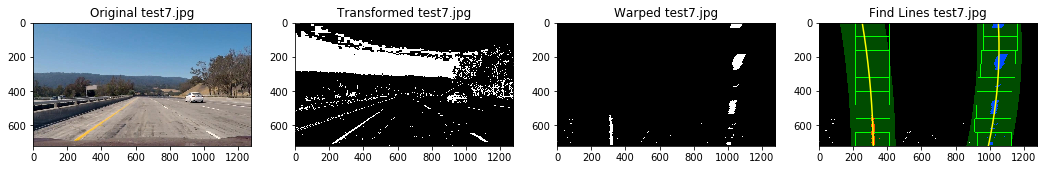

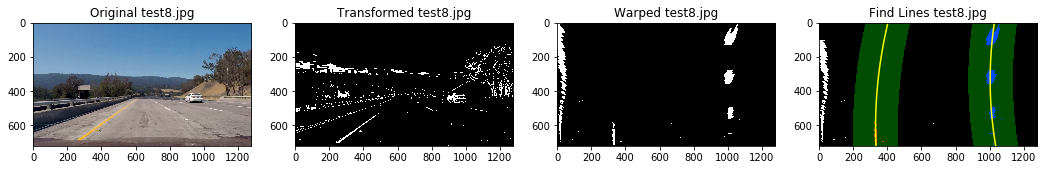

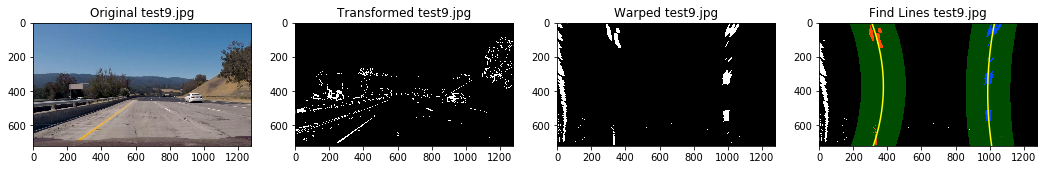

In [41]:
# Step through the list of test images to see the results of the threshold transforms
images = glob.glob('./test_images/test*.jpg')

left_fit=[]
right_fit=[]

for image_path in sorted(images):
    out_img, left_fit, right_fit = find_lane_pipeline(
        None, left_fit=left_fit, right_fit=right_fit, image_path=image_path, plot=True, save=True)

### Generate the output video by sending each image frame in it through our pipeline. It's best to use a class that will help remember the polynomials generated for a previous frame, to be used in quick lane finding for the current frame.

In [42]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class PipelineTransform(object):
    def __init__(self):
        self.left_fit = []
        self.right_fit = []
    def __call__(self, img):
        result, self.left_fit, self.right_fit = find_lane_pipeline(
            img, left_fit=self.left_fit, right_fit=self.right_fit)
        #result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        return result

process_image = PipelineTransform()

In [43]:
project_video_output = 'output_videos/project_video.mp4'
clip = VideoFileClip("./project_video.mp4")
project_video_clip = clip.fl_image(process_image)
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [02:38<00:00,  7.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 2min 48s, sys: 35.8 s, total: 3min 24s
Wall time: 2min 39s


In [44]:
challenge_video_output = 'output_videos/challenge_video.mp4'
clip = VideoFileClip("./challenge_video.mp4")
challenge_video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [01:00<00:00,  8.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 1min 4s, sys: 12.3 s, total: 1min 17s
Wall time: 1min


In [45]:
# Extract frames from video
import os
from moviepy.editor import *

def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)

movie = "./project_video.mp4"
imgdir = "./frames"
times = 22.5, 23, 23.5, 24

extract_frames(movie, times, imgdir)